<a href="https://colab.research.google.com/github/rohansiddam/Python-Journey/blob/main/102%20-%20Lesson%20102%20(Detect%20Credit%20Card%20Defaulters%20-%20ROC%20Curve).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 102: Detect Credit Card Defaulters - ROC Curve

---

### Teacher-Student Activities

In the previous lesson, you learnt to build decision tree as a Python dictionary from scratch and how to tune the hyperparameters of a decision tree to get the best classification results. In this lesson, you will learn to plot an ROC curve that is another performance evaluation parameter. It can also help us in optimising the performance of the decision tree

Let's quickly go through the activities covered in the previous lesson and begin this lesson from the **ROC-AUC Score** section.

---

#### Detect Credit Card Defaulters - Problem Statement

The Taiwanese bank has issued credit cards to many of its clients. They have maintained a dataset of credit card `DEFAULTERS` for a period from April 2005 to September 2005.

You need to build a **Decision Tree** model to predict whether or not the client will pay the credit card bill for the next month.

Predicting accurately which customers are most probable to default represents a significant business opportunity for all banks. This can improve the customer screening process and also helps in assessing the credibility of the customer. It also helps bank in reducing the spending limit of the credit card holder or initiate legal steps for amount recovery.

**Dataset Description**

The dataset contains 30,000 rows and 25 columns. Each column represents an attribute of the customer as described in the table below.

|Sr No.|Attribute|Attribute Information|
|-|-|-|
|1|ID|ID of each customer, which has been masked to display serial number to hide confidential customer information (Integer)|
|2|LIMIT_BAL|Amount of given credit in NT dollars (including supplementary creditcards) (Float)|
|3|SEX|Gender (1=male, 2=female) (Integer)|
|4|EDUCATION| (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) (Integer)|
|5|MARRIAGE|Marital status (1=married, 2=single, 3=others) (Integer)|
|6|AGE|Customer age in years (Integer)|
|7|PAY_0|Repayment status in September, 2005 (-1=paid on time, 1=payment delay for one month, 2=payment delay for two months, … , 8=payment delay for eight months and above) (Integer)|
|8|PAY_2|Repayment status in August, 2005 (scale same as above) (Integer)|
|9|PAY_3|Repayment status in July, 2005 (scale same as above) (Integer)|
|10|PAY_4|Repayment status in June, 2005 (scale same as above) (Integer)|
|11|PAY_5|Repayment status in May, 2005 (scale same as above) (Integer)|
|12|PAY_6|Repayment status in April, 2005 (scale same as above) (Integer)|
|13|BILL_AMT1|Amount of bill statement in September, 2005 (NT dollar) (Float)|
|14|BILL_AMT2|Amount of bill statement in August, 2005 (NT dollar) (Float)|
|15|BILL_AMT3|Amount of bill statement in July, 2005 (NT dollar) (Float)|
|16|BILL_AMT4|Amount of bill statement in June, 2005 (NT dollar) (Float)|
|17|BILL_AMT5|Amount of bill statement in May, 2005 (NT dollar) (Float)|
|18|BILL_AMT6|Amount of bill statement in April, 2005 (NT dollar) (Float)|
|19|PAY_AMT1|Amount of previous payment in September, 2005 (NT dollar) (Float)|
|20|PAY_AMT2|Amount of previous payment in August, 2005 (NT dollar) (Float)|
|21|PAY_AMT3|Amount of previous payment in July, 2005 (NT dollar) (Float)|
|22|PAY_AMT4|Amount of previous payment in June, 2005 (NT dollar) (Float)|
|23|PAY_AMT5|Amount of previous payment in May, 2005 (NT dollar) (Float)|
|24|PAY_AMT6|Amount of previous payment in April, 2005 (NT dollar) (Float)|
|25|default.payment.next.month|Default payment (1=yes, 0=no) (Integer)|

<br>

This data set consists of following key features:
- The payment status for 6 previous bill cycles.
- The outstanding bill amount and the repayment status along with the amount paid.
- The demographic information of the customers.

The target column of this dataset is `default.payment.next.month` which classifies the customer into two categories:
- `1` (yes) - means the customer is not going to pay for the next month bill and hence will be termed as **defaulter**.
- `0` (no) - means the customer will pay the bill for the next month and will be termed as **non-defaulter**.


Some ideas for exploration:
1. How does the probability of default payment vary by categories of different demographic variables?
2. Which features are the strongest predictors of default payment?


**Dataset Credits:** https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients


**Citation:**  Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

---

#### Recap: Decision Tree Developed so Far

Let's remodel the decision tree obtained in previous classes

Here is the link to the dataset:
https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/uci-credit-card-fraud/UCI_Credit_Card.csv

In [ ]:
# Import Python modules.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV

# Reading the dataset
cc_client_csv = 'https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/uci-credit-card-fraud/UCI_Credit_Card.csv'
df = pd.read_csv(cc_client_csv)

# Renaming the PAY_0 and default.payment.next.month columns
df.rename(columns = {"PAY_0": "PAY_1"}, inplace = True)
df.rename(columns = {"default.payment.next.month": "DEFAULT"}, inplace = True)

# Removing the redundant information from 'EDUCATION' column.
df.loc[df['EDUCATION'] == 0, 'EDUCATION'] = 5
df.loc[df['EDUCATION'] == 6, 'EDUCATION'] = 5

# Remove redundnacy in the 'MARRIAGE' column.
df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3

# Preparing features and target label, train test split
feature_columns = list(df.columns)
feature_columns.remove('DEFAULT')
feature_columns.remove('ID')

X = df[feature_columns]
y = df['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 30)

# Unpruned decision tree.
dtree_clf = DecisionTreeClassifier(random_state=20)
dtree_clf.fit(X_train, y_train)
#y_train_pred = dtree_clf.predict(X_train)
y_test_pred = dtree_clf.predict(X_test)

# Pruned decision tree
dtree_clf3 = DecisionTreeClassifier(max_depth = 3, random_state=20)
dtree_clf3.fit(X_train, y_train)
dtree_clf3_y_pred = dtree_clf3.predict(X_test)

# GridSeaechCV optimized classifier
best_tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=5,
                       random_state=20)

best_tree_clf.fit(X_train, y_train)
best_tree_clf_y_pred = best_tree_clf.predict(X_test)

Evaluation parameter for classifier models developed so far:

Evaluation Parameter | Unpruned tree | pruned tree | GridSearchCV
--- | --- |--- | ---
Misclassified cases | 2475 | 1587 | 1603
Accuracy | 0.725 | 0.824 | 0.822
Recall | 0.424 | 0.320 | 0.368
Precision | 0.376 | 0.696 | 0.652

---

#### ROC-AUC Score

A very important metric for evaluating classifier performance is **`roc_auc_score`**

- ROC: Receiver Operating Characteristics curve

- AUC: Area Under The Curve

- It is also written as AUROC (Area Under the Receiver Operating Characteristics)

Let us understand each one of them one by one.

**ROC curve**

- It is a probability curve that plots the TPR (true positive rate) against FPR (false positive rate) at various threshold values and essentially separates the `True values` from the `False values`. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. This means for values of AUC, classifier is performing well in distinguishing between defaulters and non-defaulters.

- Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test

<center><img src = "https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/roc-curve.jpeg"></center>

The ROC curve is plotted against the True Positive Rates and False Positive Rates of a classification problem for various probability thresholds. In the ROC curve above:

- The blue lines represents a random classifier generally termed as *baseline*  which exhibits poor separation among target labels. Here you will get equal number of False positives and True positives

- A good separation means `True positive rate` should be $1$ while the `Flase positive rate` should be $0$. This means a perfect classfier will be a single point at $\text{TPR} = 1$ on the y-axis.

- A classifier having ROC curve above the baseline is a potentially a good classifier and can be further improved with clever re-engineering.

 - Hence green and red lines represent better ROC curves, thus good performing classifiers.

 - More closer the ROC curve near to the TPR axis coordinate $(0,1)$ better is the separation among target labels.

- A classifier having ROC curve below the baseline is a poorly designed classifier and requires significant re-engineering, or can simply be discarded

**Steps to draw ROC curve:**

1. Adjust some threshold value that control the number of examples labelled `defaulter` and `non-defaulter`.

  For example, The threshold values can be simply determined in a way similar to grid search algorithm works:
  
  - Label the training examples with different threshold values, train classifiers with different sets of labelled examples, run the classifier on the test data, compute FPR values, and select the threshold values that cover low (close to 0) and high (close to 1) FPR values, i.e., close to 0, 0.05, 0.1, ..., 0.95, 1

2. Generate many sets of annotated examples

3. Run the classifier on the sets of examples

4. Compute a (FPR, TPR) point for each of them

5. Draw the final ROC curve

---

#### Activity 1: Plot ROC curve for Classifiers

So far we have obtained tree models for:

- Unpruned Decision Tree Classifier

- Pruned Decision Tree Classifier

- Optimised Decision Tree Classifier using `GridSearchCV`

Let us now, obtain the ROC curves and AUC scores for these decision tree models

Import the following modules:

```python
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
```

The sklearn has `roc_curve(y_true, y_score)` function which returns arrays for:

 - `fpr` - false positive rate

 - `tpr` - true positive rate

 - `thresholds`

In `roc_curve()` function:

- `y_true` represents the true values of the target class

- `y_score` represents the predicted values obtained from the classifier model


So far we have developed 3 decision trees. To plot **ROC curve** for:

- *unpruned decision tree classfier*:

  - Declare `fpr_un`, `tpr_un`, `threshold_un` and unpack the values from `roc_curve(y_test,y_test_pred)` function.

- *pruned decision tree classfier*:

  - Declare `fpr_p`, `tpr_p`, `threshold_p` and unpack the values from `roc_curve(y_test,dtree_clf3_y_pred)` function.

- *optimimised decision tree classfier from* `GridSearchCV`:

  - Declare `fpr_g`, `tpr_g`, `threshold_g` and unpack the values from `roc_curve(y_test,best_tree_clf_y_pred)` function.

In [ ]:
# S1.1: Import the required Python modules and create determine the above parameters for the decision models built so far.
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Obtain 'fpr', 'tpr' and threshold values for various classifiers
fpr1, tpr1, threshold1 = roc_curve(y_test, y_test_pred)
fpr2, tpr2, threshold2 = roc_curve(y_test, dtree_clf3_y_pred)
fpr3, tpr3, threshold3 = roc_curve(y_test, best_tree_clf_y_pred)


**Plot ROC Curve for Respective Classifiers**

For comparison plot the ROC curve for all the classifiers on same plot, call the `plt.plot(x, y, color = 'str', label = 'str')` function on object of `matplotlib.pyplot` and pass the respective parameters as per classifiers.

1. For baseline $y = x$:

  - `x = [0, 1], y = [0, 1]`

  - `linestyle = '--'` for dashed line represntation

2. For unpruned classifier: Set `x = fpr_un`, `y = tpr_un`, use `color = 'orange'`, and `label = 'Unpruned Decision Tree'`

3. For pruned classifier: Set `x = fpr_p`, `y = tpr_p`, use `color = 'green'`, and `label = 'Pruned Decision Tree'`

4. For `GridSearchCV` optimised classifier: Set `x = fpr_g`, `y = tpr_g`, use `color = 'blue'`, and `label = 'Optimised Decision Tree'`

5. Provide the title of the plot as `'ROC curve'`: Use `plt.title()`

6. Label the $x$-axis as `'False Positive rate`: Use `plt.xlabel()`

7. Label the $y$-axis as `'True Positive rate'`: Use `plt.ylabel()`

8. Provide the legend for various graphs at lower right corner of the plot: Use `plt.legend()`

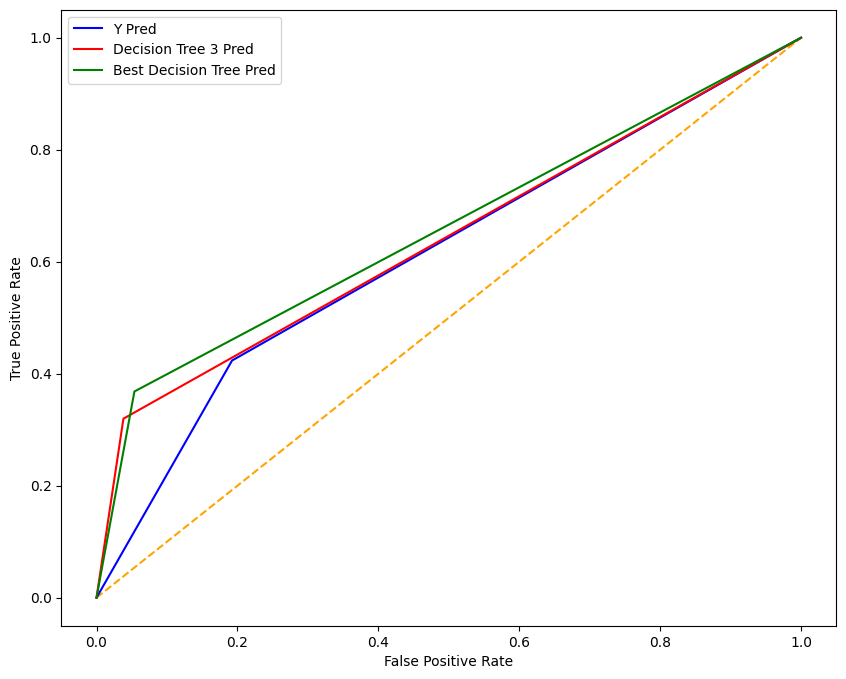

In [ ]:
# S1.2: Plot the ROC curve for various classifiers
plt.figure(figsize = (10,8))
plt.plot([0,1], [0,1], color = 'orange', linestyle = '--')
plt.plot(fpr1, tpr1, color = 'blue', label = 'Y Pred')
plt.plot(fpr2, tpr2, color = 'red', label = 'Decision Tree 3 Pred')
plt.plot(fpr3, tpr3, color = 'green', label = 'Best Decision Tree Pred')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
# Plot roc curves


Interpretation of ROC curve

- The baseline curve (dashed line) indicates that the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.


- The Optimised classifier obtained from `GridSearchCV` appears to be farther from baseline which means it is able to detect more numbers of True positives and True negatives than False negatives and False positives. Hence it should exhibit highest AUC score of the three classifiers

**Check AUC Score for Classifiers**

- Get the `auc_score` on both train and test sets by calling the `roc_auc_score()` function on the `metrics` object.

- Print these scores upto 3 decimal places using `{0:.3f}` in `.format()` method.

In [ ]:
# S1.3: Display the AUC score for classifier models obtained so far
auc_score1 = roc_auc_score(y_test, y_test_pred)
auc_score2 = roc_auc_score(y_test, dtree_clf3_y_pred)
auc_score3 = roc_auc_score(y_test, best_tree_clf_y_pred)

print(auc_score1)
print(auc_score2)
print(auc_score3)

0.6155849002742342
0.6407547172018757
0.6572456197411155


As speculated the AUC score for Optimised classifier exhibits highest value, although the values themselves do not vary much which is evident from the evaluation measures as well.

---

#### Activity 2: Balancing the Dataset
It is evident from the above decision tree and evaluation scores that we need a better optimisation procedure for improvement of the results. This is due to the fact that the dataset is **imbalanced**

Let us have a look at our dataset `target label` distribution

In [ ]:
# S2.1: Check whether the dataset is imbalanced.
df['DEFAULT'].value_counts(normalize = True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

The credit card defaulter dataset is having:

1. Majority class: `77.88%` numbers of `non-defaulters`

2. Minority class: `22.12%` numbers of `defaulters`

The dataset where we observe a huge difference in the number of `target lables` is known as **imbalanced dataset**. To model the classification problems with imbalanced dataset **Resampling** is performed.

But before resampling create a DataFrame of features by dropping `ID` and `DEEFAULT` columns from the `df`. Name this DataFrame as `df_features`.


In [ ]:
# S2.2: Copy feature columns to a new DataFrame
df_features = df.drop(columns = ['ID', 'DEFAULT'], axis = 1)

#### Resampling - Undersampling

Undersampling is a process in which we decrease the number of majority samples to match the number of minority samples.

![](https://s3-whjr-curriculum-uploads.whjr.online/442c3f7a-9448-4ba2-b146-db8fe0ca2c52.png)

For undersampling:

1. Import the `RandomUnderSampler` class from the `imblearn.under_sampling` module.

2. Create an object of the `RandomUnderSampler` class. Inside its constructor pass:
   
      - `random_state = 30` parameter to ensure that the same samples are created every time you run the code. The value of the `random_state` parameter has to just some integer.

3. Call the `fit_resample()` function on the object of the `RandomUnderSampler` class to complete the resampling process. The `fit_resample()` function takes both feature and target arrays and returns corresponding resampled NumPy arrays.

In [ ]:
# S2.3: Undersampling
from imblearn.under_sampling import RandomUnderSampler
rus1 = RandomUnderSampler(random_state = 30)
features1, targets1 = rus1.fit_resample(df_features, df['DEFAULT'])

Print the counts of the `Non-Defaulter` and `DEFAULTER` customers for the undersampled dataset:

In [ ]:
# S2.4: Print the shape of the resampled arrays and counts of the nonad and ad samples.
targets1.value_counts()

0    6636
1    6636
Name: DEFAULT, dtype: int64

#### Resampling - Oversampling
Oversampling/upsampling is a process in which we increase the number of minority samples to match the number of majority samples. This is done by creating multiple copies of the dataset occurring in the minority dataset.

![](https://s3-whjr-curriculum-uploads.whjr.online/f5beca63-743d-4e17-a420-99f52ac61396.png)

For Oversampling:

1. Import the `RandomOverSampler` class from the `imblearn.over_sampling` module.

2. Create an object of the `RandomOveerSampler` class. Inside its constructor pass:
   
   

   - `random_state = 30` parameter to ensure that the same samples are created every time you run the code. The value of the `random_state` parameter has to just some integer.

3. Call the `fit_resample()` function on the object of the `RandomOverSampler` class to complete the resampling process. The `fit_resample()` function takes both feature and target arrays and returns corresponding resampled NumPy arrays.




In [ ]:
# S2.5: Oversampling
from imblearn.over_sampling import RandomOverSampler
rus2 = RandomOverSampler(random_state = 30)
features2, targets2 = rus2.fit_resample(df_features, df['DEFAULT'])

Print the counts of the `Non-Defaulter` and `DEFAULTER` customers for the oversampled dataset:

In [ ]:
# S2.6: Print the shape of the resampled arrays and counts of the nonad and ad samples.
targets2.value_counts()

1    23364
0    23364
Name: DEFAULT, dtype: int64

---

#### Activity 3: Modeling the Decision Tree for Oversampled Dataset

Let us model the Decision Tree Classifier for the oversampled dataset. Split the oversampled data into train and test dataset. Use `random_state=30` for consistent results

In [ ]:
# S3.1: Perform train-test split.
X = features2
Y = targets2

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 30, test_size = 0.33)


Now let's build a decision tree classifier for the upsampled dataset.

Next run the `GridSearchCV` for classifier optimisation.

1. First define a `param_grid` to select which parameters from `DecisionTreeCalssifier` class you want to run the optimisation. Let us Set:

 - `max_depth`: 4 to 21 (In pruning we saw that accuracy reduces when tree depth increases)

 - `random_state`: [42] (for consistent results)

2. Construct a decision tree grid `grid_tree` using `GridSearchCV` function with following inputs:

 - `DecisionTreeClassifier`: The classifier model we want to deploy

 - `param_grid`: the set of parameters for which classifier performance would be evaluated.

 - `scoring`: use roc_auc as the scoring criteria as it provides better information for misclassified cases.

3. Call the `fit()` function on the `grid_tree` to find the best fit.

 - Use `X_train_up` and `y_train_up` as input.

4. Create an object best_tree and assign it the best decision tree model using `best_estimator_` attribute from `GridSearchCV`

5. `print(best_tree)` to display the parameters for the best classifier returned by `GridSearchCV`

6. Print the cross validation score achieved by the best classifier using `grid_tree.best_score_` and display the score in percentage.

7. Get predictions form the best_tree on the upsampled test dataset :`x_test_up`

 - Print the recall score for the upsampled test dataset.

In [ ]:
# S3.2: Use GridSeachCV for optimising the classifier performance

# Create a grid
params = {'criterion' : ['gini', 'entropy'], 'max_depth' : np.arange(4,20), 'random_state' : [42]}

# Training
gscv = GridSearchCV(DecisionTreeClassifier(), params, scoring = 'roc_auc', n_jobs = -1)
gscv.fit(x_train, y_train)

# Get cross-validated score
print(gscv.best_estimator_)

# Get score on upsampled test dataset


DecisionTreeClassifier(criterion='entropy', max_depth=19, random_state=42)


Now, let's rebuild the decision tree classifier model for the upsampled sets with the best parameters obtained above.

Copy the result obtained from the `GridSeacrhCV` for determining the classifier obtained from upsampled dataset `up_tree_clf`.

1. Model the tree using the `balanced` dataset for optimal fitting.

2. Classifier should perform well for the real-world data. Hence for evaluation use the imbalance dataset.

3. Call the `fit()` function on `up_tree_clf` constructor with upsampled train features and upsampled target variables as inputs.

4. Get the predicted target values for both train and test sets by calling the `predict()` function on `dtree_clf`

5. Plot the confusion matrix for `y_test` using `up_tree_clf_pred`

6. Get the `classification_report`

In [ ]:
dtree_clf4 = DecisionTreeClassifier(criterion='entropy', max_depth=19, random_state=42)
dtree_clf4.fit(x_train, y_train)
#y_train_pred = dtree_clf.predict(X_train)
y_test_pred2 = dtree_clf4.predict(x_test)
dtree_clf4.score(x_train, y_train)
dtree4_pred = dtree_clf4.predict(x_test)

In [ ]:
# S3.3: Model the best fit tree
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

Let's visualise the decision tree classifier for the upsampled sets.

In [ ]:
# S3.5: Visualising the decision tree.
sio = StringIO()
export_graphviz(dtree_clf4, out_file = sio, feature_names = feature_columns, class_names = ['0','1'])

In [ ]:
graph = pydotplus.graph_from_dot_data(sio.getvalue())
graph.write_png('DecisionTree4Visualizer.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.26419 to fit



True

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.26419 to fit



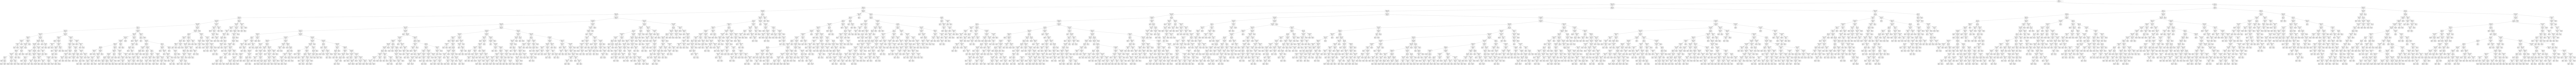

In [ ]:
Image(graph.create_png())

This is a huge tree, hence:

- Difficult to comprehend

- May require more computational resources

- Will have a tendency of overfitting

---

#### Activity 4: Modeling the Decision Tree for Downsampled Dataset

Let us model the Decision Tree Classifier for the downsampled dataset. Split the downsampled data into train and test dataset. Use `random_state=30` for consistent results

In [ ]:
# S4.1: Perform train test split
X = features1
Y = targets1

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 30, test_size = 0.33)

Now let's build a decision tree classifier for the downsampled dataset.

Next run the `GridSearchCV` for classifier optimisation.

- First define a `param_grid` to select which parameters from `DecisionTreeCalssifier` class you want to run the optimisation. Let us set:

 - `max_depth`: 4 to 21 (In pruning we saw that accuracy reduces when tree depth increases)

 - `random_state`: [42] (for consistent results)

- Construct a decision tree grid `grid_tree` using `GridSearchCV` function with following inputs:

 - `DecisionTreeClassifier`: The classifier model we want to deploy

 - `param_grid`: the set of parameters for which classifier performance would be evaluated.

 - `scoring`: use recall as the scoring criteria as it provides better information for misclassified cases.

- Call the `fit()` function on the `grid_tree` to find the best fit.

  - Use `X_train_dn` and `y_train_dn` as input.

- Create an object best_tree and assign it the best decision tree model using `best_estimator_` attribute from `GridSearchCV`

- `print(best_tree)` to display the parameters for the best classifier returned by `GridSearchCV`

- Print the cross validation score achieved by the best classifier using `grid_tree.best_score_` and display the score in percentage.

- Get predictions form the best_tree on the upsampled test dataset: `x_test_dn`

- Print the recall score for the upsampled test dataset

In [ ]:
# S4.2: Use 'GridSeachCV' for optimising the classifier performance

params = {'criterion' : ['gini', 'entropy'], 'max_depth' : np.arange(4,21), 'random_state' : [42]}

# Training
gscv2 = GridSearchCV(DecisionTreeClassifier(), params, scoring = 'roc_auc', n_jobs = -1)
gscv2.fit(x_train, y_train)

# Get cross-validated score
print(gscv2.best_estimator_)


DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)


Now, let's rebuild the decision tree classifier model for the downsampled sets with the best parameters obtained above.

Copy the result obtained from the `GridSearchCV` for determining the classifier obtained from downsampled dataset `dn_tree_clf`.

- Model the tree using the `balanced` dataset for optimal fitting.
  
- Classifier should perform well for the real-world data. Hence for evaluation use the imbalance dataset.

- Call the `fit()` function on `dn_tree_clf` constructor with upsampled train features and downsampled target variables as inputs.

- Get the predicted target values for both train and test sets by calling the `predict()` function on `dtree_clf`

- Plot the confusion matrix for `y_test` using `dn_tree_clf_pred`

- Get the `classification_report`

In [ ]:
# S4.3: Model the best fit tree
dtree_clf5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dtree_clf5.fit(x_train, y_train)
#y_train_pred = dtree_clf.predict(X_train)
y_test_pred3 = dtree_clf4.predict(x_test)
dtree_clf5.score(x_train, y_train)
dtree5_pred = dtree_clf5.predict(x_test)

Let's visualise the decision tree classifier for the downsampled sets.

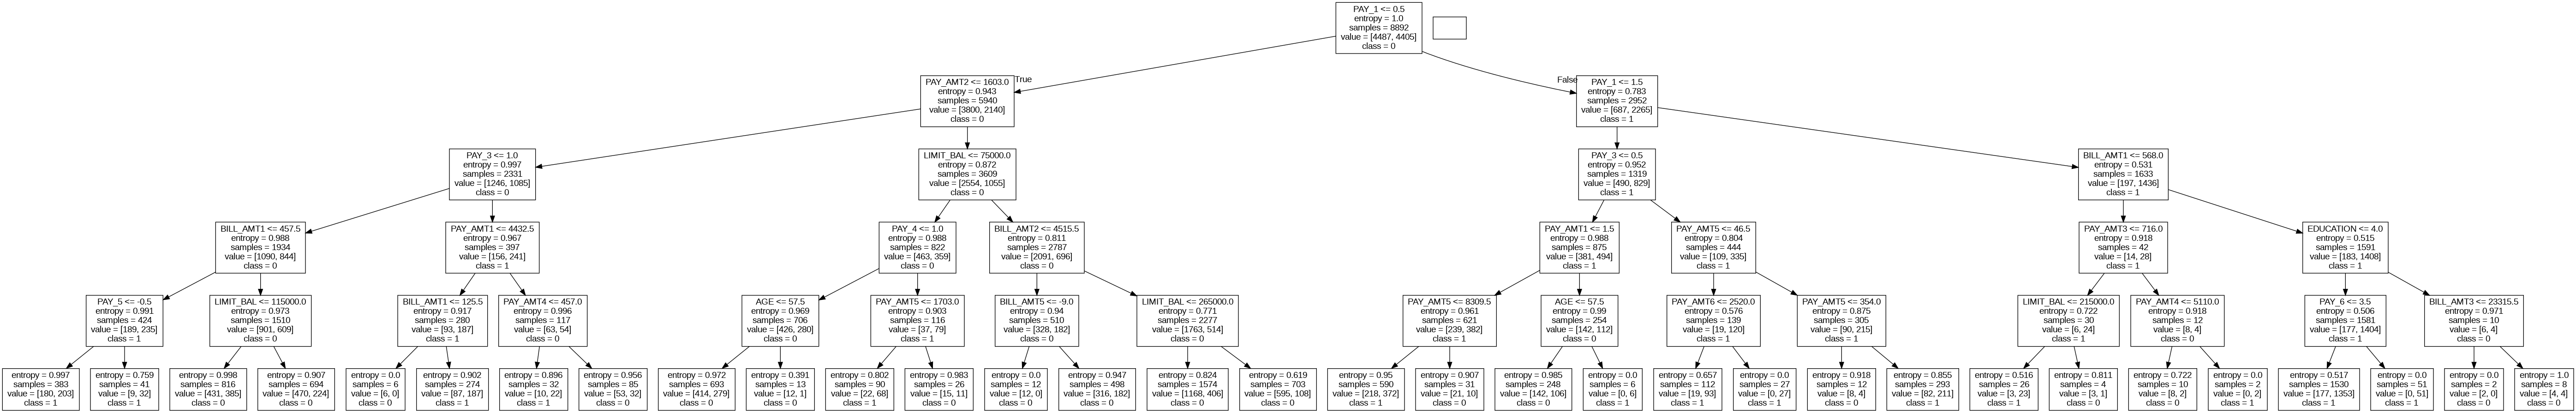

In [ ]:
# S4.4: visualize the downsampled decision tree
sio = StringIO()
export_graphviz(dtree_clf5, out_file = sio, feature_names = feature_columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(sio.getvalue())
graph.write_png('DecisionTree5Visualizer.png')

Image(graph.create_png())

By observing the leaf nodes we can say that the performance for this classifier is so far the best as we have achieved a better class separation.

Let us verify the classifier performance

---

#### Activity 5: Evaluating the Classifier Models

- Use `roc_curve(y_true, y_score)` function which returns arrays for:

  - `fpr` - false positive rate

  - `tpr` - true positive rate

  - `thresholds`

To recall `roc_curve()` function:

- `y_true` represents the true values of the target class

- `y_score` represents the predicted values obtained from the classifier model


Next, plot **ROC curve** for upsampled and downsampled decision tree classifier:

1. Optimimised decision tree classfier from upsampled dataset:

 - Declare `fpr_up`, `tpr_up`, `threshold_up` and unpack the values from `roc_curve(y_test,up_tree_clf_pred)` function.

2. Optimimised decision tree classfier from downsampled dataset:

 - Declare `fpr_dn`, `tpr_dn`, `threshold_dn` and unpack the values from `roc_curve(y_test,dn_tree_clf_pred)` function.

In [ ]:
# S5.1: Obtain fpr, tpr and threshold values for upsampled and downsampled classifiers
fpr4, tpr4, threshold4 = roc_curve(y_test, dtree4_pred)
fpr5, tpr5, threshold5 = roc_curve(y_test, dtree5_pred)

Now that we have `fpr` and `tpr` values. Let us plot the ROC curve for respective classifiers.

1. For comparison plot the ROC curve for all the classifiers on same plot, Call the `plt.plot(x, y, color = 'str', label = 'str')` function on object of `matplotlib.pyplot` and pass the respective parameters as per classifiers.

2. For baseline $y = x$:

 - `x = [0, 1], y = [0, 1]`

 - `linestyle = '--'` for dashed line represntation

3. For upsampled classifier:

  - Set `x = fpr_up, y = tpr_up`, use `color = 'orange'`, and `label = 'Upsampled Decision Tree'`

4. For downsampled classifier:

  - Set `x = fpr_dn, y = tpr_dn`, use `color = 'green'`, and `label = 'downsampled Decision Tree'`

5. For unpruned classifier:

  - Set `x = fpr_un, y = tpr_un`, use `color = 'yellow'`, and `label = 'Unpruned Decision Tree'`

6. For pruned classifier:

  - Set `x = fpr_p, y = tpr_p`, use `color = 'black'`, and `label = 'Pruned Decision Tree'`

7. For `GridSearchCV` optimised classifier:

  - Set `x = fpr_g, y = tpr_g`, use `color = 'blue'`, and `label = 'Optimised Decision Tree'`

8. Provide the title of the plot as `'ROC curve'`: Use `plt.title()`

9. Label the $x$-axis as `'False Positive rate'`: Use `plt.xlabel()`

10. Label the $y$-axis as `'True Positive rate'`: Use `plt.ylabel()`

11. Provide the legend for various graphs at lower right corner of the plot: Use `plt.legend()`

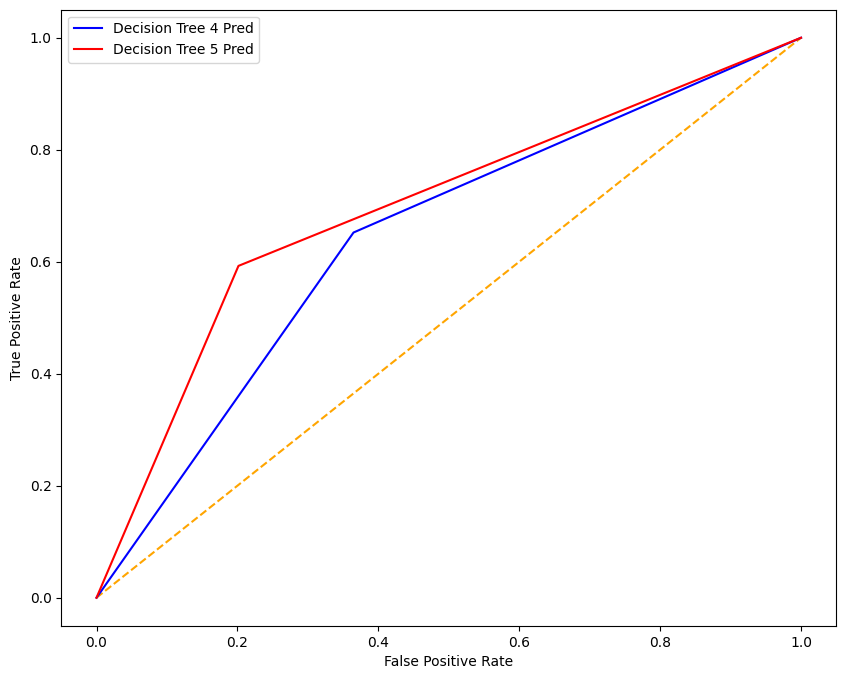

In [ ]:
# S5.2: Plot the ROC curve for various classifiers

# Plot roc curves.
plt.figure(figsize = (10,8))
plt.plot([0,1], [0,1], color = 'orange', linestyle = '--')
plt.plot(fpr4, tpr4, color = 'blue', label = 'Decision Tree 4 Pred')
plt.plot(fpr5, tpr5, color = 'red', label = 'Decision Tree 5 Pred')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Interpretation from ROC Curve

- Performance of Pruned and GridSearchCV based classifiers are very similar.

- The classifiers obtained from Balanced dataset performs best.

- The Oversampled Classifier should exhibit the highest AUC score


In [ ]:
# S5.3 Display the AUC score for upsampled and downsampled classifier models


let's now compare the performances.

For upsampled classifier we have:
- `False Positive` count of 915
- `False Negative` count of 182

For downsampled classifier we have:
- `False Positive` count of 1497
- `False Negative` count of 759

For GridSearchCV optimised classifier we had:

- `False Positive` count of 1223
- `False Negative` count of 380

For pruned decision tree we had:

- `False Positive` count of 270
- `False Negative` count of 1317

For unpruned classifier we had:

- `False Positive` count of 1359
- `False Negative` count of 1116

Evaluation Parameter comparison

Evaluation Parameter | Unpruned tree | pruned tree | GridSearchCv optimised | upsampled | downsampled
--- | --- |--- | --- | --- | ---
Misclassified cases | 2475 | 1587 | 1603 | 1097 | 2256
Accuracy | 0.725 | 0.824 | 0.822 | 0.878 | 0.754
Recall | 0.424 | 0.320 | 0.368 | 0.664 | 0.544
Precision | 0.376 | 0.696 | 0.652 | 0.869 | 0.476
AUC score | 0.616 | 0.641 | 0.657 | 0.889 | 0.703


---

####Conclusion

There is no fixed strategy for optimising the results of the classifier design.
1. For balanced datasets `GridSearchCV` can be used and performance can be evaluated for various hyperparameters and we can get a suitable classifier with good performance.

2. For imbalanced datasets no matter how much we try to optimise the hyperparameters, the classifier performance will still be inadequate and we need to balance: `resample` the dataset for improving classifier performance.

 - For resampling utilise both the strategies `oversampling` and `undersampling` strategies

 - Evaluate the classifier performance to get the optimum classifier design.

3. For each execution training and testing parameters might vary a bit. However, there should not be a huge differences in the classifier performance.

4. With oversampling the classifier performance has been improved. We are able to get good performance scores.

5. While modeling for the payment status you might encounter the status `-2` and `0`. The status `-2` stands for zero bill amount for the respective bill cycle, hence no payment required. The status `0` stands for payment of the minimum due amount, but not the entire balance. i.e., the customer paid enough for their account to remain in good standing, but did revolve a balance. However, this does not affects the model.


---

### **Project**
You can now attempt the **Capstone Project 19 - Early Diabetes Prediction Web App** on your own.

**Capstone Project 19 - Early Diabetes Prediction Web App**: https://colab.research.google.com/drive/1YTyQ05Cki451s-mJh9j2fhcfIrSPvDiJ

---